In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import pandas as pd

# Load data
df = pd.read_csv("pharma_Q4_FY24_with_ratios.csv")

# Quick view
print(df.head())
print(df.info())

            Company         Ticker    Net Income  Operating Income  \
0        Sun Pharma   SUNPHARMA.NS  2.654580e+10      2.478990e+10   
1       Dr. Reddy's     DRREDDY.NS  1.307000e+10      1.327800e+10   
2             Cipla       CIPLA.NS  9.390400e+09      1.156150e+10   
3       Divi's Labs    DIVISLAB.NS  5.380000e+09      6.430000e+09   
4  Aurobindo Pharma  AUROPHARMA.NS  9.087500e+09      1.402130e+10   

        Revenue          COGS        Equity          Debt  Current Assets  \
0  1.181333e+11  3.787460e+10  6.366675e+11  3.273670e+10    4.347498e+11   
1  7.083000e+10  2.934700e+10  2.805500e+11  2.002000e+10    2.480490e+11   
2  6.082370e+10  2.822930e+10  2.670643e+11  5.594100e+09    1.944141e+11   
3  2.254000e+10  1.042000e+10  1.357100e+11  3.000000e+07    9.675000e+10   
4  7.491920e+10  3.694190e+10  2.984280e+11  6.647630e+10    2.420563e+11   

   Current Liabilities  ...  Current Ratio  Debt to Equity  \
0         1.698440e+11  ...       2.559701        0.05

## K Means Clustering

In [18]:
from sklearn.preprocessing import StandardScaler

company_names = df["Company"].copy()


# Select numeric ratio columns for clustering
ratio_columns = [
    "Current Ratio", "Debt to Equity", "Inventory Turnover",
    "Return on Equity (ROE)", "Operating Margin", "P/E Ratio",
    "Book Value per Share", "Asset Turnover", "Debt Ratio", "Net Profit Margin"
]

# Subset the DataFrame
df_ratios = df[ratio_columns].copy()

# Scale
scaler = StandardScaler()
scaled_ratios = scaler.fit_transform(df_ratios)

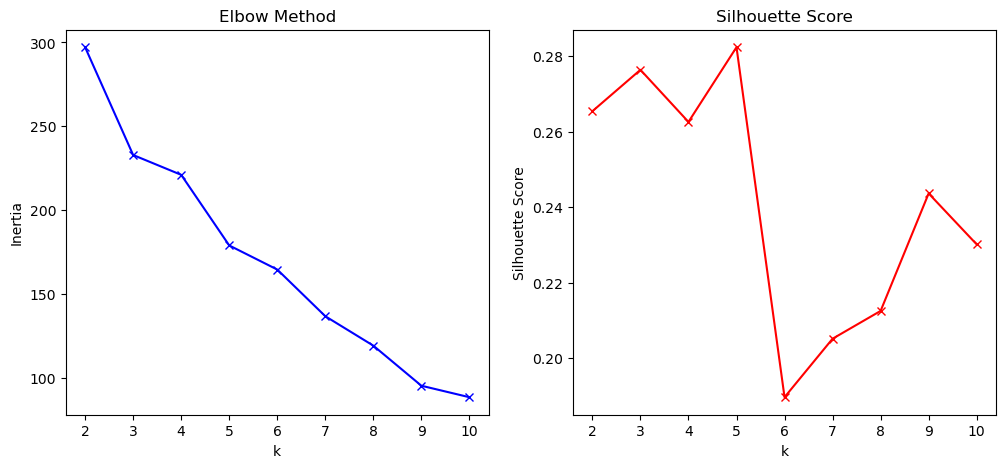

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow method
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_ratios)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled_ratios, kmeans.labels_))

# Plot elbow and silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, 'rx-')
plt.xlabel('k'); plt.ylabel('Silhouette Score'); plt.title('Silhouette Score')
plt.show()

The "elbow" appears to be around k=3 or k=4. After k=4, the decrease in inertia becomes less substantial.

The silhouette score peaks at k=5 (around 0.28).

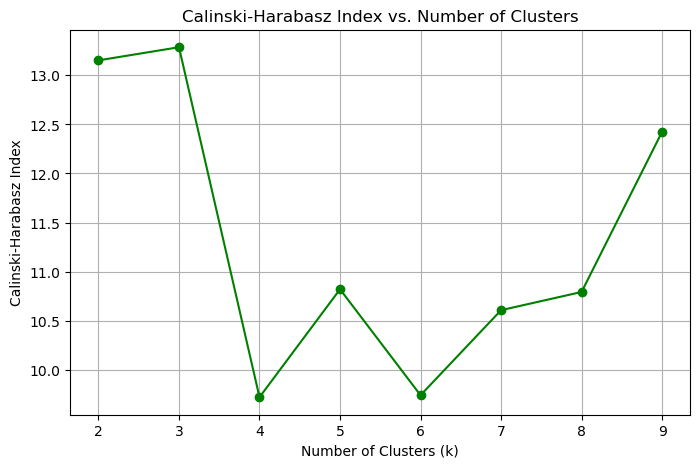

In [23]:
# Range of clusters
K = range(2, 10)
from sklearn.metrics import calinski_harabasz_score

ch_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(scaled_ratios)
    score = calinski_harabasz_score(scaled_ratios, labels)
    ch_scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, ch_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs. Number of Clusters')
plt.grid(True)
plt.xticks(K)
plt.show()

The Calinski-Harabasz Index is highest at k = 3, that is again a strong indicator.

Given the conflicting signals, a choice between k=3 and k=5 is most reasonable.

We'll be going ahead with k=3 due to its strong support from the Calinski-Harabasz Index and the Elbow Method. The Silhouette score at k=3 is very close to the peak at k=5.

In [24]:
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(scaled_ratios)

# Cluster characteristics
cluster_profiles = df.groupby('KMeans_Cluster')[df_ratios.columns].mean()
cluster_profiles.head()

,Current Ratio,Debt to Equity,Inventory Turnover,Return on Equity (ROE),Operating Margin,P/E Ratio,Book Value per Share,Asset Turnover,Debt Ratio,Net Profit Margin
KMeans_Cluster,,,,,,,,,,
0,1.372301,0.730700,0.509785,0.021134,0.146406,43.443719,174.031740,0.153877,0.322810,0.068188
1,3.661625,0.087013,0.594246,0.038308,0.172663,41.351537,327.440174,0.190633,0.057381,0.160002
2,1.484140,0.321006,0.435481,-0.086761,0.036023,-152.123557,273.455261,0.140539,0.157279,-0.328353


In [36]:
# This is the correct 1D array of cluster labels
clusters = kmeans.fit_predict(scaled_ratios)

# Now safely assign cluster labels
df_result = df_ratios.copy()
df_result["Company"] = company_names.values  # Ensure index aligns
df_result["KMeans_Cluster"] = clusters.astype(int)

# Sort by cluster
df_result = df_result.sort_values(by="KMeans_Cluster")

In [37]:
df_result

,Current Ratio,Debt to Equity,Inventory Turnover,Return on Equity (ROE),Operating Margin,P/E Ratio,Book Value per Share,Asset Turnover,Debt Ratio,Net Profit Margin,Company,KMeans_Cluster
23,2.028785,0.837505,0.474273,0.016964,0.226850,52.939439,343.009054,0.119658,0.368958,0.062457,Hester Biosciences,0
37,1.277526,0.688393,0.900905,0.028604,0.121635,54.986413,96.322090,0.206159,0.328721,0.066255,Hikal,0
38,1.613979,0.625123,0.488884,0.037641,0.203719,46.446078,53.108409,0.144602,0.304717,0.126886,Gufic Bio,0
18,1.264625,0.518268,0.281446,0.013547,0.140695,83.870450,184.955264,0.094143,0.303048,0.084143,Shilpa Medicare,0
17,1.312391,0.742800,0.716000,-0.001388,0.131656,211.682353,26.273961,0.232258,0.316605,-0.002546,Sequent Scientific,0
16,1.559078,0.605418,0.463897,0.020443,0.029746,-152.256250,120.430175,0.204723,0.313305,0.051677,Indoco Remedies,0
15,1.032381,1.184093,0.444754,0.008551,0.150828,19.604770,230.631580,0.158214,0.430988,0.019671,Strides Pharma,0
7,1.034327,0.586618,0.342565,0.065544,0.256872,56.159561,202.577972,0.178965,0.267051,0.166727,Torrent Pharma,0
31,0.909164,1.075461,0.665374,0.027440,0.178352,62.264073,189.897504,0.077639,0.394571,0.129667,Eris Lifesciences,0
9,0.988306,0.822733,0.270677,0.006849,0.036182,39.095745,165.131124,0.068909,0.290289,0.035069,Biocon,0


1. **Cluster 0**: "High Leverage, Moderate Profitability, Value Play"

Current Ratio (1.37): This is the lowest current ratio, indicating weaker short-term liquidity compared to the other clusters. They might have less ability to cover immediate liabilities

Debt to Equity (0.73) & Debt Ratio (0.32): These are the highest debt metrics, signifying that companies in this cluster rely significantly on debt financing. This implies higher financial risk

Inventory Turnover (0.51): Moderate, better than Cluster 2 but lower than Cluster 1

Asset Turnover (0.154): Second lowest, suggesting moderate efficiency in generating sales from assets

ROE (2.1%), Operating Margin (14.6%), Net Profit Margin (6.9%): These are moderate profitability figures. They are profitable, but not as strong as Cluster 1

P/E Ratio (43.44): The highest P/E ratio (though close to Cluster 1). This could suggest that despite the higher leverage, investors still have relatively high growth expectations, or perhaps these are stable companies perceived as having long-term value despite slower growth

Book Value per Share (174.03): The lowest book value per share.

2. **Cluster 1**: "Financially Robust, Highly Profitable, Efficient Growth"

Current Ratio (3.66): Highest current ratio, indicating excellent short-term liquidity and strong ability to meet current obligations

Debt to Equity (0.087) & Debt Ratio (0.057): Lowest debt metrics, signifying very little reliance on debt financing and a highly conservative financial structure. This suggests minimal financial risk

Inventory Turnover (0.59): Highest inventory turnover, indicating highly efficient management of inventory

Asset Turnover (0.191): Highest asset turnover, meaning they are most efficient at generating sales from their assets

ROE (3.8%), Operating Margin (17.3%), Net Profit Margin (16.0%): Highest profitability ratios, demonstrating superior operational efficiency and strong ability to convert revenue into profit for shareholders

P/E Ratio (41.35): Very high P/E ratio (second highest, very close to Cluster 0), indicating strong investor confidence and high growth expectations

Book Value per Share (327.44): Highest book value per share, suggesting a strong underlying asset base per share

3. **Cluster 2**: "Underperforming/Distressed, Low Profitability, Operational Challenges"

Current Ratio (1.48): Similar to Cluster 0, indicating limited short-term liquidity

Debt to Equity (0.32) & Debt Ratio (0.157): Moderate debt levels, higher than Cluster 1 but lower than Cluster 0

Inventory Turnover (0.44): Lowest inventory turnover, suggesting inefficiencies in managing inventory

Asset Turnover (0.141): Lowest asset turnover, indicating they are least efficient at utilizing their assets to generate sales

ROE (-8.7%) & Net Profit Margin (-32.8%): Significantly negative values for both ROE and Net Profit Margin. This is the defining characteristic, indicating that companies in this cluster are, on average, incurring substantial losses and are struggling to generate profit from their operations and assets

Operating Margin (3.6%): Also the lowest operating margin, confirming weak operational profitability

P/E Ratio (-152.12): A negative P/E ratio indicates net losses. Investors typically use other metrics for valuing loss-making companies, but a negative P/E signals current unprofitability

Book Value per Share (273.45): Second highest book value, which might be a positive, but overshadowed by the severe unprofitability

## Feature Ranking

In [38]:
from sklearn.feature_selection import f_classif

# Features and target
X = df_result[ratio_columns]
y = df_result["KMeans_Cluster"]

# Calculate F-scores and p-values
f_scores, p_values = f_classif(X, y)

# Create a DataFrame for ranking
anova_ranking = pd.DataFrame({
    'Feature': ratio_columns,
    'F-Score': f_scores,
    'p-value': p_values
}).sort_values(by='F-Score', ascending=False)

print("ANOVA F-value Ranking:")
print(anova_ranking)

ANOVA F-value Ranking:
                  Feature    F-Score       p-value
8              Debt Ratio  73.746843  1.233315e-13
9       Net Profit Margin  65.538181  6.916064e-13
1          Debt to Equity  61.515549  1.713763e-12
3  Return on Equity (ROE)  48.259935  4.888017e-11
5               P/E Ratio  17.158937  5.340253e-06
0           Current Ratio   6.812779  3.026149e-03
6    Book Value per Share   2.521419  9.406530e-02
7          Asset Turnover   2.497931  9.603107e-02
4        Operating Margin   1.665591  2.029432e-01
2      Inventory Turnover   0.710715  4.978765e-01


In [39]:
from sklearn.ensemble import RandomForestClassifier

# Fit random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': ratio_columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importances)


Random Forest Feature Importance:
                  Feature  Importance
8              Debt Ratio    0.230713
1          Debt to Equity    0.198436
0           Current Ratio    0.196685
9       Net Profit Margin    0.127296
3  Return on Equity (ROE)    0.097351
4        Operating Margin    0.034739
5               P/E Ratio    0.034311
2      Inventory Turnover    0.027889
7          Asset Turnover    0.027531
6    Book Value per Share    0.025050


In [40]:
# Merge both rankings
combined_ranking = pd.merge(anova_ranking, rf_importances, on="Feature")
print("\nCombined Feature Ranking:")
print(combined_ranking.sort_values(by='F-Score', ascending=False))


Combined Feature Ranking:
                  Feature    F-Score       p-value  Importance
0              Debt Ratio  73.746843  1.233315e-13    0.230713
1       Net Profit Margin  65.538181  6.916064e-13    0.127296
2          Debt to Equity  61.515549  1.713763e-12    0.198436
3  Return on Equity (ROE)  48.259935  4.888017e-11    0.097351
4               P/E Ratio  17.158937  5.340253e-06    0.034311
5           Current Ratio   6.812779  3.026149e-03    0.196685
6    Book Value per Share   2.521419  9.406530e-02    0.025050
7          Asset Turnover   2.497931  9.603107e-02    0.027531
8        Operating Margin   1.665591  2.029432e-01    0.034739
9      Inventory Turnover   0.710715  4.978765e-01    0.027889


1. **Debt Ratio** - High F-score + highest importance => key separator between clusters (debt-heavy vs low-debt firms)
2. **Net Profit Margin** - Profitability clearly differentiates performance levels
3. **Debt to Equity** - Tied closely with leverage
4. **Return on Equity (ROE)** - Measures efficiency and profitability
5. **Current Ratio** - Liquidity indicator; useful for cluster separation in Random Forest

## Agglomerative Clustering with Dendrogram

In [41]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns

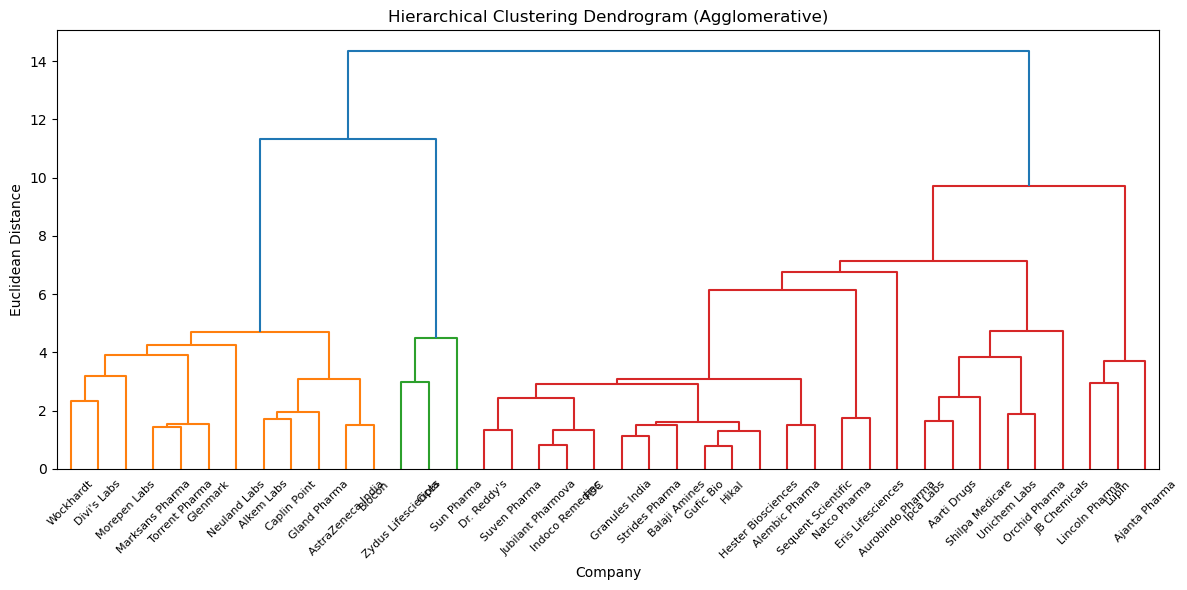

In [42]:
# Computing the linkage matrix
linked = linkage(scaled_ratios, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked,
           labels=df_result["Company"].values,  # use company names
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram (Agglomerative)")
plt.xlabel("Company")
plt.ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()

In [46]:
# Create 3 clusters from the dendrogram
agglo_clusters = fcluster(linked, t=3, criterion='maxclust')

# Assign back to DataFrame
df_result["Agglo_Cluster"] = agglo_clusters.astype(int)

# Preview
df_result.sort_values(by="Agglo_Cluster")

,Current Ratio,Debt to Equity,Inventory Turnover,Return on Equity (ROE),Operating Margin,P/E Ratio,Book Value per Share,Asset Turnover,Debt Ratio,Net Profit Margin,Company,KMeans_Cluster,Agglo_Cluster
23,2.028785,0.837505,0.474273,0.016964,0.226850,52.939439,343.009054,0.119658,0.368958,0.062457,Hester Biosciences,0,1
39,6.710976,0.011439,0.792637,0.039512,0.228524,25.303877,531.421314,0.177419,0.009178,0.178676,Balaji Amines,1,1
10,3.048718,0.009890,0.378012,0.056829,0.251420,34.985054,285.576246,0.217093,0.007606,0.201319,Ajanta Pharma,1,1
20,4.841290,0.001799,0.975245,0.031370,0.120415,12.528594,295.978422,0.190151,0.001523,0.139658,Lincoln Pharma,1,1
13,4.135999,0.065965,0.411849,0.065999,0.433082,8.436720,326.788007,0.151789,0.055905,0.368501,Natco Pharma,1,1
11,2.115849,0.106505,0.404602,0.036987,0.138126,32.708614,245.121910,0.217274,0.079614,0.127251,Alembic Pharma,1,1
22,3.433387,0.009784,0.466646,0.022068,0.101012,27.922156,128.810822,0.184065,0.008314,0.101876,FDC,1,1
5,1.581797,0.204458,0.419296,0.025152,0.149762,27.615127,312.960101,0.203987,0.121755,0.073426,Lupin,1,1
4,1.984210,0.222755,0.376642,0.030451,0.187152,20.028442,513.820559,0.166223,0.147491,0.121297,Aurobindo Pharma,1,1
1,2.582794,0.071360,0.461779,0.046587,0.187463,18.135043,337.198300,0.182779,0.051662,0.184526,Dr. Reddy's,1,1


**Agglo_Cluster 1**: "Balanced, Moderately Leveraged, and Profitable"

Current Ratio (2.73): Indicates good short-term liquidity, suggesting they can meet current obligations

Debt to Equity (0.36) & Debt Ratio (0.18): These are the highest debt metrics among the three clusters, suggesting a moderate to higher reliance on debt financing compared to the other groups

Inventory Turnover (0.56): Shows good inventory management

Asset Turnover (0.17): Moderate efficiency in generating sales from assets

ROE (3%), Operating Margin (14%), Net Profit Margin (10%): These are solid, positive profitability figures, indicating healthy operations.

P/E Ratio (29.17): This is the highest P/E ratio, suggesting positive investor sentiment and expectations for future growth, despite having higher debt

Book Value per Share (235.83): The lowest among the clusters

This cluster appears to consist of companies that are profitable and operationally efficient, but they utilize a comparatively higher amount of debt in their capital structure. Investors seem to view them favorably, possibly expecting future growth that justifies their P/E ratio.

**Agglo_Cluster 2**: "Financially Conservative, Highly Profitable, and Efficient"

Current Ratio (2.81): Strong liquidity, similar to other clusters

Debt to Equity (0.04) & Debt Ratio (0.03): These are exceptionally low debt metrics, making this cluster the most financially conservative. They rely very little on borrowed capital, indicating very low financial risk

Inventory Turnover (0.49): Slightly lower inventory turnover than others, but still reasonable

Asset Turnover (0.17): Moderate efficiency

ROE (5%), Operating Margin (22%), Net Profit Margin (20%): These are the highest profitability metrics across all clusters, showcasing superior operational excellence and a strong ability to convert sales into profit

P/E Ratio (26.07): High, reflecting confidence in their strong profitability

Book Value per Share (264.36): Moderate

This cluster represents the "top performers" in terms of financial health and profitability. They are very conservative with debt, highly profitable, and generally efficient, making them very attractive from a financial stability and earnings perspective.

**Agglo_Cluster 3**: "Asset-Rich, Operationally Efficient, but Moderately Profitable"

Current Ratio (2.98): Highest current ratio, indicating the strongest short-term liquidity

Debt to Equity (0.22) & Debt Ratio (0.10): Moderate debt levels, higher than Cluster 2 but lower than Cluster 1

Inventory Turnover (0.56): Tied for highest inventory turnover

Asset Turnover (0.19): Highest asset turnover, indicating the most efficient use of assets to generate sales

ROE (2%), Operating Margin (16%): Good profitability, but lower than Cluster 2. (Net Profit Margin is not available)

P/E Ratio (24.28): The lowest P/E ratio, suggesting more moderate investor expectations compared to the other clusters

Book Value per Share (367.16): Highest book value per share, indicating a strong asset base per share

Companies in this cluster appear to be asset-heavy and exceptionally efficient in using those assets to generate sales. While they maintain good profitability, it's not as high as Cluster 2. Their high book value and strong asset turnover suggest mature, possibly capital-intensive businesses that are well-managed operationally.

In [47]:
cluster_summary = df_result.groupby("Agglo_Cluster")[ratio_columns].mean().round(2)
print(cluster_summary)

               Current Ratio  Debt to Equity  Inventory Turnover  \
Agglo_Cluster                                                      
1                       2.73            0.36                0.56   
2                       2.81            0.04                0.49   
3                       2.98            0.22                0.56   

               Return on Equity (ROE)  Operating Margin  P/E Ratio  \
Agglo_Cluster                                                        
1                                0.03              0.14      29.17   
2                                0.05              0.22      26.07   
3                                0.02              0.16      24.28   

               Book Value per Share  Asset Turnover  Debt Ratio  \
Agglo_Cluster                                                     
1                            235.83            0.17        0.18   
2                            264.36            0.17        0.03   
3                            367.16     

Profitability Spectrum: Cluster 2 stands out as the most profitable, followed by Cluster 3, and then Cluster 1.

Financial Leverage Spectrum: Cluster 2 is the most conservative (lowest debt), Cluster 3 is moderately leveraged, and Cluster 1 uses the most debt.

Efficiency Variations: Cluster 3 shows the highest overall operational efficiency (Asset Turnover), while Cluster 1 and 2 are more balanced.

Valuation vs. Fundamentals: Cluster 1 has the highest P/E ratio despite higher debt and slightly lower profitability than Cluster 2, suggesting different investor perceptions or growth prospects. Cluster 3 has the highest asset base (Book Value) and efficiency, but the lowest P/E, which could imply a focus on stable rather than high-growth returns.

## Comparing the clustering

In [49]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix

kmeans_labels = df_result["KMeans_Cluster"]
agglo_labels = df_result["Agglo_Cluster"]

# Adjusted Rand Index
ari_score = adjusted_rand_score(kmeans_labels, agglo_labels)
print(f"\nAdjusted Rand Index (ARI): {ari_score:.3f}")

# Contingency Table
contingency = pd.crosstab(kmeans_labels, agglo_labels)
print("\nContingency Table (KMeans vs Agglomerative):")
print(contingency)


Adjusted Rand Index (ARI): -0.029

Contingency Table (KMeans vs Agglomerative):
Agglo_Cluster    1  2  3
KMeans_Cluster          
0               10  0  2
1               14  3  8
2                1  0  2


KMeans cluster 0 mostly maps to Agglo cluster 1 (10 points), but also spills into cluster 3 (2 points).

KMeans cluster 1 spreads widely — 14 in Agglo cluster 1, 3 in 2, and 8 in 3 — showing high inconsistency.

KMeans cluster 2 barely aligns with any single Agglo cluster.

=> The two methods are forming distinct clusterings

## Outlier detection

In [51]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso.fit_predict(scaled_ratios)

# -1 indicates outlier, 1 indicates normal
outliers = df_ratios[outlier_labels == -1]
print(f"Number of outliers detected: {len(outliers)}")
print(outliers)

Number of outliers detected: 4
    Current Ratio  Debt to Equity  Inventory Turnover  Return on Equity (ROE)  \
12       1.276613        0.156848            0.581445               -0.155236   
25       2.393291        0.104772            0.265622               -0.054736   
29       0.782515        0.701399            0.459375               -0.050313   
35       2.611755        0.006447            1.282487                0.055454   

    Operating Margin   P/E Ratio  Book Value per Share  Asset Turnover  \
12          0.122896 -198.351955            278.097073        0.210048   
25         -0.004697 -155.447942            335.543208        0.121231   
29         -0.010130 -102.570773            206.725503        0.090339   
35          0.124073  207.224681            284.768000        0.355466   

    Debt Ratio  Net Profit Margin  
12    0.085728          -0.403939  
25    0.078096          -0.336547  
29    0.308014          -0.244573  
35    0.004258           0.103023  


In [53]:
outlier_indices = [12, 25, 29, 35]
outlier_companies = df_result.loc[outlier_indices, 'Company']
print(outlier_companies)

12             Glenmark
25         Unichem Labs
29            Wockhardt
35    AstraZeneca India
Name: Company, dtype: object


Glenmark - KMeans: Cluster 2, Agglomerative: Cluster 3

AstraZeneca - KMeans: Cluster 1, Agglomerative: Cluster 3

Unichem Labs - KMeans: Cluster 2, Agglomerative: Cluster 1

Wockhardt - KMeans: Cluster 2, Agglomerative: Cluster 3

These companies do not cluster cleanly, indicating they are financial outliers. 
Outlier detection and clustering converge on the same companies, reinforcing the result.

1. Glenmark has negative ROE and Net Profit Margin
2. Wockhardt and Unichem Labs also have large negative margins and extreme P/E ratios
3. AstraZeneca has unusually high P/E but otherwise decent fundamentals, this could signal market overvaluation